<a href="https://colab.research.google.com/github/LeonidIsaev/ML-HSE/blob/main/Lab1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Первичный анализ данных

In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [3]:
def plot_hist_categorial_attribute(data, attribute): 
    """
    Функция отображения распределния категориальных признаков.
    """
    counts = []
    values = set(data[attribute])
    for i in values:
        counts.append(data[data[attribute] == i].count()[0])
        print("{} - {:f} %".format(i,(counts[-1]/len(data[attribute]))*100))
    plt.subplots(figsize=(8,5))
    values = list(values)
    plt.barh(values,counts, color='r')

In [4]:
df_train = pd.read_csv("credit_train.csv")

In [5]:
df_train

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Описание признаков
1. Loan ID - ID кредита
2. Customer ID - ID клиента
3. Loan Status - Статус кредита (Целевой, бинарный)
  1. Fully Paid - полностью выплачен
  2. Charged Off - списан
4. Current Loan Amount - Текущая сумма кредита
5. Term - Срок кредита
  1. Long Term - Долгосрочный
  2. Short Term - Кратковременный
6. Credit Score - Кредитный рейтинг
7. Annual Income - Годовой доход
8. Years in current job - Стаж на текущей работе
9. Home Ownership - Место проживания
10. Purpose - Цель кредита
11. Monthly Debt - Ежемесячный платеж
12. Years of Credit History - Количество лет кредитной истории
13. Months since last delinquent - Количество месяцев с последнего проступка
14. Number of Open Accounts - Количество открытых счетов
15. Number of Credit Problems - Количество проблем с кредитами
16. Current Credit Balance - Количество средств на счету, сумма которой может свободно распоряжется заемщик
17. Maximum Open Credit - Оценка всех средств
18. Bankruptcies - Наличие банкротсва
19. Tax Liens - Налоговые льготы






Избавимся от признаков "Loan ID" и "Customer ID"

In [6]:
df_train = df_train.drop(["Loan ID", "Customer ID"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проанализируем признаки

In [7]:
df_train.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.000000e+05,80846.000000,8.084600e+04,100000.000000,100000.000000,46859.000000,100000.00000,100000.000000,1.000000e+05,9.999800e+04,99796.000000,99990.000000
mean,1.176045e+07,1076.456089,1.378277e+06,18472.412336,18.199141,34.901321,11.12853,0.168310,2.946374e+05,7.607984e+05,0.117740,0.029313
std,3.178394e+07,1475.403791,1.081360e+06,12174.992609,7.015324,21.997829,5.00987,0.482705,3.761709e+05,8.384503e+06,0.351424,0.258182
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.796520e+05,705.000000,8.488440e+05,10214.162500,13.500000,16.000000,8.00000,0.000000,1.126700e+05,2.734380e+05,0.000000,0.000000
50%,3.122460e+05,724.000000,1.174162e+06,16220.300000,16.900000,32.000000,10.00000,0.000000,2.098170e+05,4.678740e+05,0.000000,0.000000
75%,5.249420e+05,741.000000,1.650663e+06,24012.057500,21.700000,51.000000,14.00000,0.000000,3.679588e+05,7.829580e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.00000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


Заметим, что количество значений разнится, что говорит о наличи пропусков.

По MIN все значения положительные, единственные вопросы вызывает 0 в признаке "Monthly Debt".

По MAX тоже все не плохо, кроме разве "Credit Score" 7510 или 70 лет кредитной истории, необходимо подробнее рассмотреть данные признаки.

STD отличается от MEAN, что говорит о разбросе данных.

Удалим объекты, для которых целевой признак равен Nan

In [8]:
df_train = df_train.dropna(subset=['Loan Status']) 
df_train.shape

(100000, 17)

In [9]:
Fully_Paid = df_train[df_train['Loan Status'] == "Fully Paid"]
Charged_Off = df_train[df_train['Loan Status'] == "Charged Off"]
print("Процент класса Fully_Paid {:f}%".format(len(Fully_Paid)/len(df_train)))
print("Процент класса Charged_Off {:f}%".format(len(Charged_Off)/len(df_train)))

Процент класса Fully_Paid 0.773610%
Процент класса Charged_Off 0.226390%


Классы не сбалансированы

Рассмотрим остальные признаки

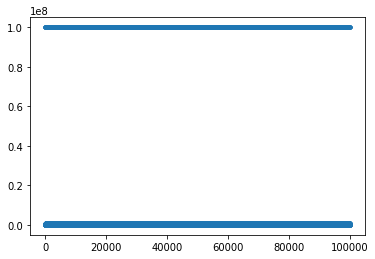

In [10]:
plt.plot(df_train["Current Loan Amount"], ".") 
pass                                           

Можем наблюдать выбросы, заменим значения медианой

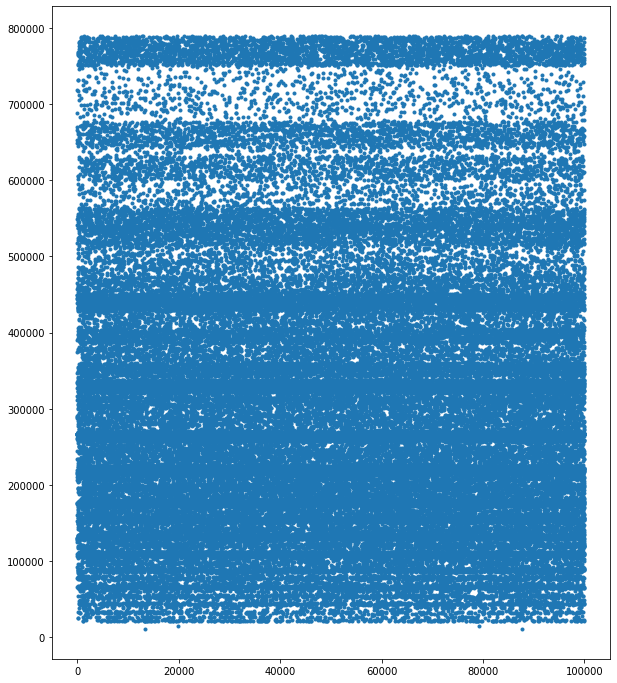

In [11]:
df_train["Current Loan Amount"].max() 
df_train = df_train.replace({'Current Loan Amount': {99999999.0: df_train[df_train["Current Loan Amount"] != 99999999.0]["Current Loan Amount"].median()}})
plt.figure(figsize=(10,12))
plt.plot(df_train["Current Loan Amount"], ".")
pass

In [12]:
df_train.shape

(100000, 17)

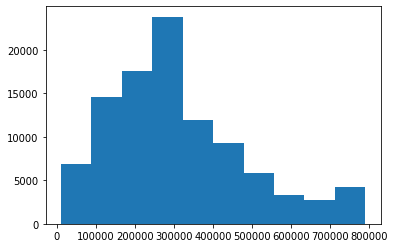

In [13]:
plt.hist(df_train["Current Loan Amount"]) 
pass

От выбросов избавились, рассмотрим количество пропущеных данных в признаках

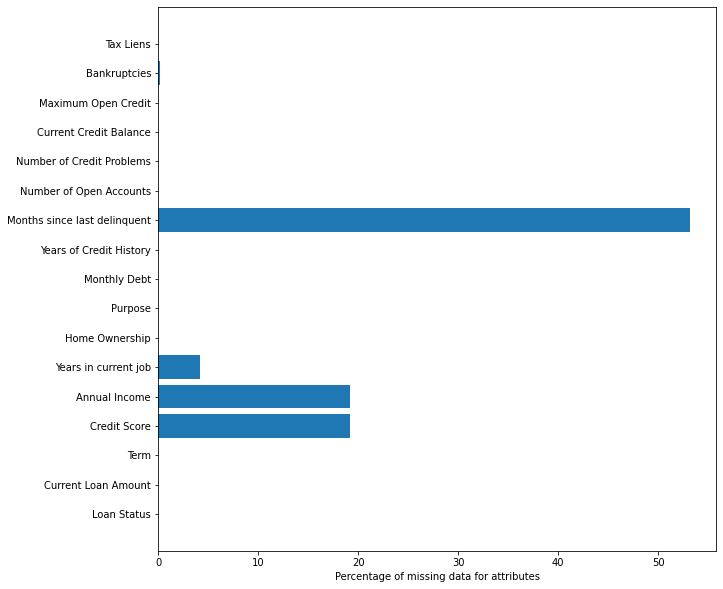

In [14]:
plt.figure(figsize=(10,10))
plt.barh(df_train.columns, (df_train.isnull().sum()/len(df_train))*100)
plt.xlabel("Percentage of missing data for attributes")
pass

Для признака "Months since last delinquent" пропущено более 50% данных, исключим его из набора данных. Остальные признаки попробуем заполнить медианой после первичного анализа

In [15]:
df_train = df_train.drop(["Months since last delinquent"], axis = 1)
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,267344.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Fully Paid,147070.0,Short Term,725.0,475437.0,7 years,Own Home,other,2202.86,22.3,5.0,0.0,47766.0,658548.0,0.0,0.0
99996,Fully Paid,267344.0,Short Term,732.0,1289416.0,1 year,Rent,Debt Consolidation,13109.05,9.4,22.0,0.0,153045.0,509234.0,0.0,0.0
99997,Fully Paid,103136.0,Short Term,742.0,1150545.0,6 years,Rent,Debt Consolidation,7315.57,18.8,12.0,1.0,109554.0,537548.0,1.0,0.0
99998,Fully Paid,530332.0,Short Term,746.0,1717524.0,9 years,Rent,Debt Consolidation,9890.07,15.0,8.0,0.0,404225.0,738254.0,0.0,0.0


Short Term - 72.208000 %
Long Term - 27.792000 %


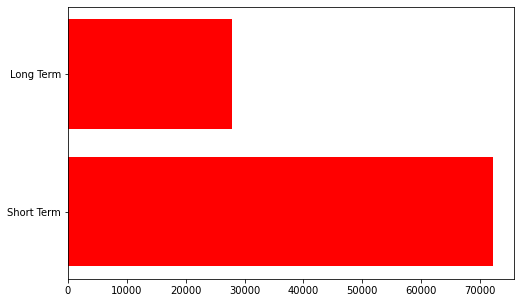

In [16]:
plot_hist_categorial_attribute(df_train, "Term")

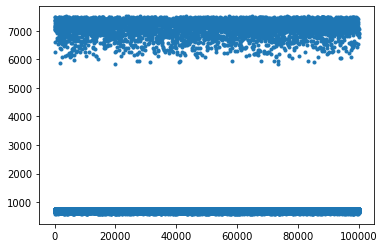

In [17]:
plt.plot(df_train["Credit Score"], ".") 
pass

Признак разделен на 2 непересекающихся класса

4551


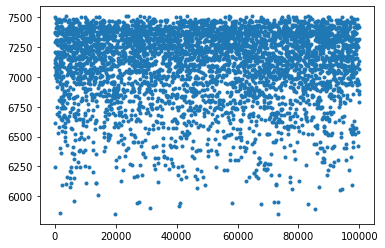

In [18]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]>2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

76295


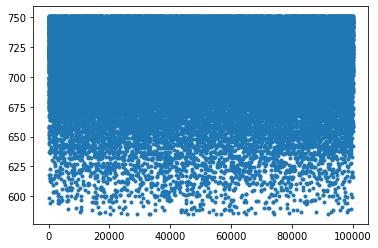

In [19]:
Credit_Score = df_train["Credit Score"][df_train["Credit Score"]<2000 ]
print(len(Credit_Score))
plt.plot(Credit_Score, ".") 
pass

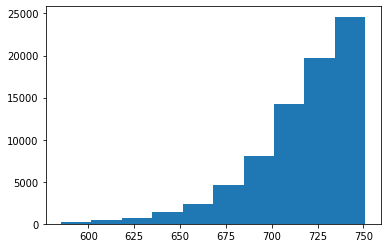

In [20]:
plt.hist(Credit_Score) 
pass

Разобьем признаки на 2 кластера

Fully Paid - 81.049566 %
Charged Off - 18.950434 %


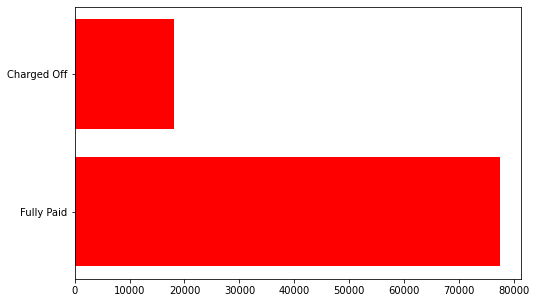

In [21]:
df_train2 = df_train[df_train["Credit Score"].isnull()]
df_train3 = df_train[df_train["Credit Score"]<2000 ]
lower = df_train3.append(df_train2)
lower["Credit Score"] = lower["Credit Score"].fillna(lower["Credit Score"].median()) 
plot_hist_categorial_attribute(lower, "Loan Status")

Charged Off - 100.000000 %


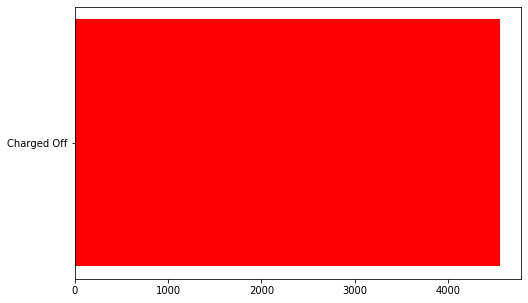

In [22]:
upper = df_train[df_train["Credit Score"]>2000]
plot_hist_categorial_attribute(upper, "Loan Status")

Кластер "Upper" нам не подходит, поскольку 100 принадлежат 1 классу.

In [23]:
df_train = copy.deepcopy(lower)

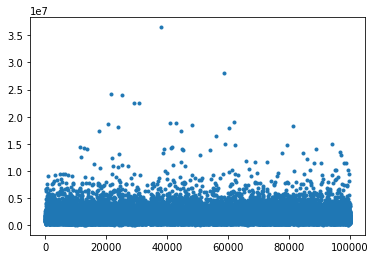

In [24]:
plt.plot(df_train["Annual Income"], ".") 
pass

Видим выбросы, избавимся от них

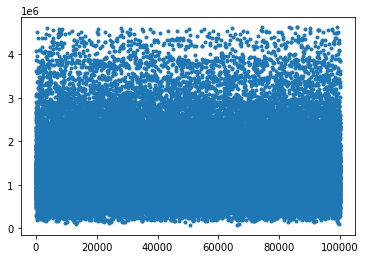

In [25]:
plt.plot(df_train["Annual Income"][df_train["Annual Income"]<df_train['Annual Income'].quantile(0.99)], ".")
pass

(95386, 16)

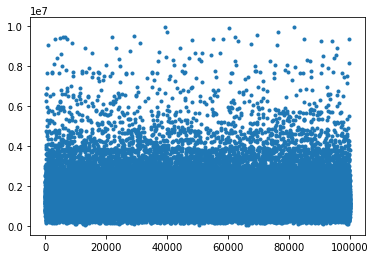

In [26]:
plt.plot(df_train[df_train["Annual Income"]<0.01*10**9]["Annual Income"], ".")

df_train2 = df_train[df_train["Annual Income"].isnull()]
df_train3 = df_train[df_train["Annual Income"]<0.01*10**9 ]
df_train4 = df_train3.append(df_train2)
df_train4["Annual Income"] = df_train4["Annual Income"].fillna(df_train4["Annual Income"].median()) 
df_train = copy.deepcopy(df_train4)
df_train.shape

Рассмотрим распеделение "Years in current job" без пропущенных значений

3 years - 8.522044 %
9 years - 4.124275 %
4 years - 6.448966 %
7 years - 5.786019 %
< 1 year - 8.527513 %
6 years - 5.914014 %
5 years - 7.104256 %
10+ years - 32.533640 %
1 year - 6.700580 %
2 years - 9.550377 %
8 years - 4.788316 %


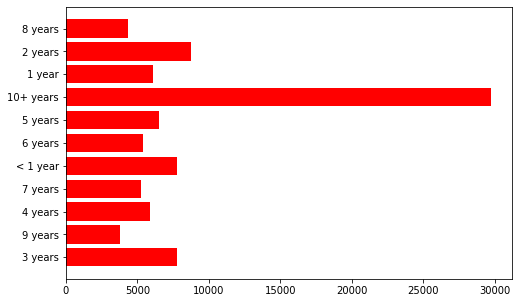

In [27]:
plot_hist_categorial_attribute(df_train.dropna(subset=["Years in current job"]), "Years in current job")

Заполним пропуски модой

In [28]:
tmp = {"Years in current job":"10+ years"}
df_train = df_train.fillna(tmp)

Рассмотрим "Home Ownership"

Own Home - 9.161722 %
Rent - 42.008261 %
Home Mortgage - 48.613004 %
HaveMortgage - 0.217013 %


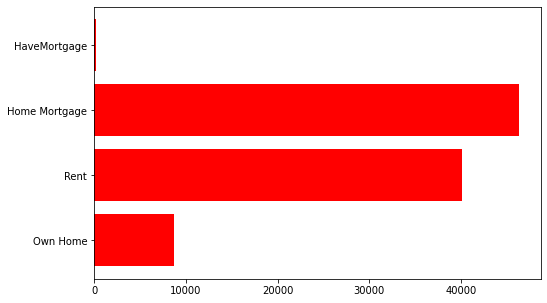

In [29]:
plot_hist_categorial_attribute(df_train, "Home Ownership")

"HaveMortgage" по смыслу совпадает с "Home Mortgage". Приведем их к одному значению

In [30]:
df_train = df_train.replace({'Home Ownership': {"HaveMortgage": "Home Mortgage"}})

Educational Expenses - 0.100644 %
Other - 3.287694 %
wedding - 0.119514 %
Medical Bills - 1.121758 %
small_business - 0.274673 %
Buy House - 0.676200 %
major_purchase - 0.347011 %
moving - 0.146772 %
vacation - 0.100644 %
Business Loan - 1.548445 %
Debt Consolidation - 78.477974 %
other - 6.056444 %
Buy a Car - 1.275869 %
Home Improvements - 5.881366 %
Take a Trip - 0.575556 %
renewable_energy - 0.009435 %


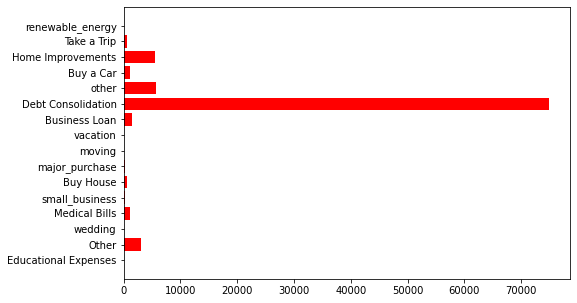

In [31]:
plot_hist_categorial_attribute(df_train, "Purpose")

In [32]:
df_train = df_train.replace({'Purpose': {"other": "Other"}})
df_train = df_train.replace({'Purpose': {"Take a Trip": "vacation"}})

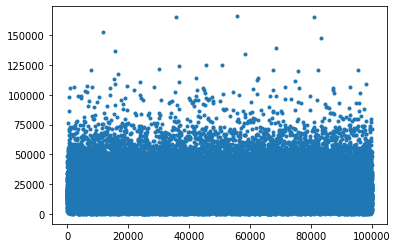

In [33]:

plt.plot(df_train["Monthly Debt"], ".")
pass

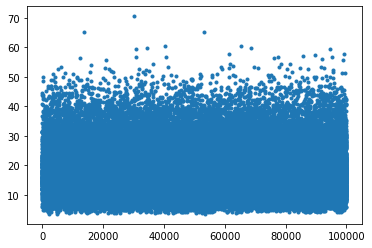

In [34]:
plt.plot(df_train["Years of Credit History"], ".")
pass

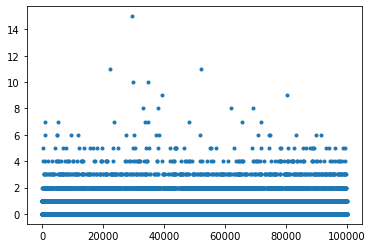

In [35]:
plt.plot(df_train["Number of Credit Problems"], ".")
pass

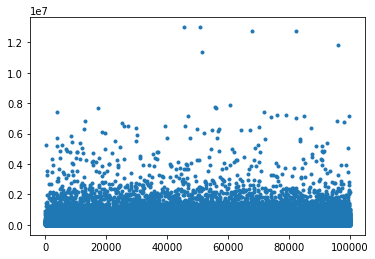

In [36]:
plt.plot(df_train["Current Credit Balance"], '.')
pass

In [37]:
df_train = df_train[df_train["Current Credit Balance"]<1*10**7] 
df_train.shape

(95380, 16)

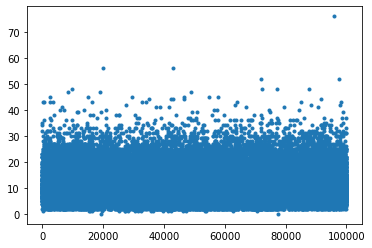

In [38]:
plt.plot(df_train["Number of Open Accounts"], ".")
pass

In [39]:
df_train = df_train[df_train["Number of Open Accounts"] < 60]

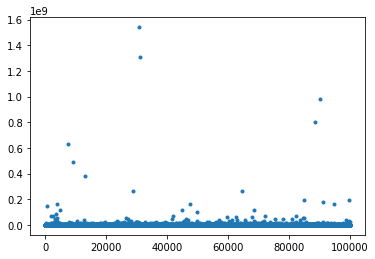

In [40]:
plt.plot(df_train["Maximum Open Credit"], '.')
pass

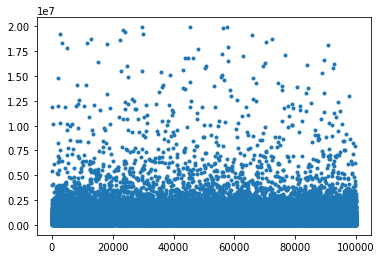

In [41]:
plt.plot(df_train[df_train["Maximum Open Credit"] < 0.02*10**9]["Maximum Open Credit"], ".")
pass

In [42]:
df_train = df_train[df_train["Maximum Open Credit"] < 0.02*10**9]

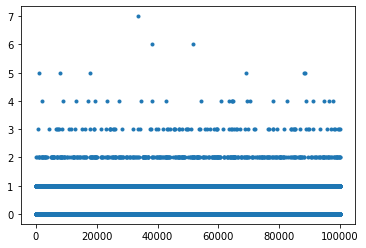

In [43]:
plt.plot(df_train["Bankruptcies"], ".") 
pass

In [44]:
print(len(df_train[df_train["Bankruptcies"]>=2]))
df_train = df_train[df_train["Bankruptcies"]<2]
df_train.shape

527


(94582, 16)

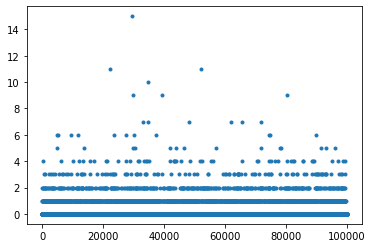

In [45]:
plt.plot(df_train["Tax Liens"], ".")
pass

In [46]:
print(len(df_train[df_train["Tax Liens"]>=2]))
df_train = df_train[df_train["Tax Liens"]<2]
df_train.shape

530


(94052, 16)

In [47]:
df_train.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

Векторизуем категориальные признаки

In [48]:
df_train_copy = copy.deepcopy(df_train)

In [49]:
df_train.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,94052.000000,94052.000000,9.405200e+04,94052.000000,94052.000000,94052.000000,94052.000000,9.405200e+04,9.405200e+04,94052.000000,94052.000000
mean,306234.031940,717.732680,1.331645e+06,18441.409986,18.190044,11.121029,0.139721,2.924017e+05,6.550239e+05,0.105399,0.013163
std,175012.113482,25.218508,7.307426e+05,11956.361232,7.010197,4.998686,0.377163,3.338216e+05,8.379338e+05,0.307069,0.113973
min,15422.000000,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,179624.500000,710.000000,9.367475e+05,10212.642500,13.500000,8.000000,0.000000,1.130310e+05,2.746260e+05,0.000000,0.000000
50%,267344.000000,722.000000,1.183073e+06,16231.035000,16.900000,10.000000,0.000000,2.101970e+05,4.701070e+05,0.000000,0.000000
75%,400642.000000,735.000000,1.510776e+06,24009.112500,21.700000,14.000000,0.000000,3.689040e+05,7.862800e+05,0.000000,0.000000
max,789250.000000,751.000000,9.939280e+06,165810.530000,70.500000,56.000000,6.000000,7.888952e+06,1.992184e+07,1.000000,1.000000


In [50]:
categorical_columns = [c for c in df_train.columns if df_train[c].dtype.name == 'object']
numerical_columns   = [c for c in df_train.columns if df_train[c].dtype.name != 'object']

In [51]:
data_describe = df_train.describe(include = [object])
for c in categorical_columns:
    df_train[c] = df_train[c].fillna(data_describe[c]['top'])

In [52]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Loan Status', 'Term'] ['Years in current job', 'Home Ownership', 'Purpose']


In [53]:
for binary in binary_columns:
  elements =  df_train[binary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[binary] == i, binary] = number
    number = number + 1.0
  df_train[binary] = df_train[binary].astype('int64')
  

In [54]:
for nonbinary in nonbinary_columns:
  elements =  df_train[nonbinary].unique()
  number = 0.0
  for i in elements:
    df_train.at[df_train[nonbinary] == i, nonbinary] = number
    number = number + 1.0
  df_train[nonbinary] = df_train[nonbinary].astype('int64')

In [55]:
df_train

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0,445412.0,0,709.0,1167493.0,0,0,0,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
2,0,267344.0,0,741.0,2231892.0,0,1,1,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,0,347666.0,1,721.0,806949.0,1,1,1,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
6,0,217646.0,0,730.0,1184194.0,2,0,1,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0
8,0,548746.0,0,678.0,2559110.0,3,2,1,18660.28,22.6,4.0,0.0,437171.0,555038.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99978,0,431860.0,1,722.0,1183073.0,5,0,1,8465.07,18.5,5.0,0.0,241319.0,476806.0,0.0,0.0
99982,0,484968.0,1,722.0,1183073.0,5,0,1,20941.80,23.7,15.0,0.0,804175.0,1322662.0,0.0,0.0
99988,1,309474.0,0,722.0,1183073.0,5,0,1,13817.18,26.9,15.0,0.0,225872.0,892606.0,0.0,0.0
99989,1,429132.0,0,722.0,1183073.0,5,0,1,28948.02,16.3,16.0,0.0,485279.0,656414.0,0.0,0.0


In [56]:
df_train.describe()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,94052.000000,94052.000000,94052.000000,94052.000000,9.405200e+04,94052.000000,94052.000000,94052.000000,94052.000000,94052.000000,94052.000000,94052.000000,9.405200e+04,9.405200e+04,94052.000000,94052.000000
mean,0.189342,306234.031940,0.274136,717.732680,1.331645e+06,4.756486,0.931315,1.511674,18441.409986,18.190044,11.121029,0.139721,2.924017e+05,6.550239e+05,0.105399,0.013163
std,0.391782,175012.113482,0.446080,25.218508,7.307426e+05,2.516999,0.950757,1.555180,11956.361232,7.010197,4.998686,0.377163,3.338216e+05,8.379338e+05,0.307069,0.113973
min,0.000000,15422.000000,0.000000,585.000000,7.662700e+04,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,179624.500000,0.000000,710.000000,9.367475e+05,3.000000,0.000000,1.000000,10212.642500,13.500000,8.000000,0.000000,1.130310e+05,2.746260e+05,0.000000,0.000000
50%,0.000000,267344.000000,0.000000,722.000000,1.183073e+06,5.000000,1.000000,1.000000,16231.035000,16.900000,10.000000,0.000000,2.101970e+05,4.701070e+05,0.000000,0.000000
75%,0.000000,400642.000000,1.000000,735.000000,1.510776e+06,6.000000,2.000000,1.000000,24009.112500,21.700000,14.000000,0.000000,3.689040e+05,7.862800e+05,0.000000,0.000000
max,1.000000,789250.000000,1.000000,751.000000,9.939280e+06,10.000000,2.000000,13.000000,165810.530000,70.500000,56.000000,6.000000,7.888952e+06,1.992184e+07,1.000000,1.000000


In [57]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan Status,1.000000,0.048734,0.103255,-0.075368,-0.070709,0.006701,0.050671,0.005115,0.008034,-0.021269,0.010173,-0.000226,-0.009094,-0.036476,-0.005033,0.004666
Current Loan Amount,0.048734,1.000000,0.405886,-0.190187,0.376352,0.026001,-0.183033,-0.175980,0.412479,0.146585,0.188820,-0.089313,0.337503,0.254781,-0.094369,0.011498
Term,0.103255,0.405886,1.000000,-0.419666,0.107218,0.019825,-0.116578,-0.062846,0.159121,0.041633,0.082185,-0.027264,0.115162,0.073707,-0.026353,-0.004053
Credit Score,-0.075368,-0.190187,-0.419666,1.000000,-0.014450,-0.006780,-0.038697,-0.062696,-0.082166,0.070367,-0.026658,-0.042375,-0.017385,0.079203,-0.030219,-0.014694
Annual Income,-0.070709,0.376352,0.107218,-0.014450,1.000000,0.014283,-0.199290,-0.026952,0.534463,0.184439,0.168391,-0.042899,0.344087,0.272409,-0.055673,0.030118
Years in current job,0.006701,0.026001,0.019825,-0.006780,0.014283,1.000000,-0.066593,-0.022005,0.036057,0.045598,0.018466,0.014740,0.027920,0.016190,0.015393,0.005985
Home Ownership,0.050671,-0.183033,-0.116578,-0.038697,-0.199290,-0.066593,1.000000,0.095326,-0.208031,-0.199403,-0.137434,-0.008374,-0.181344,-0.164884,-0.004630,-0.006865
Purpose,0.005115,-0.175980,-0.062846,-0.062696,-0.026952,-0.022005,0.095326,1.000000,-0.085955,-0.027243,-0.090432,-0.013974,-0.076950,-0.038408,-0.019643,-0.000447
Monthly Debt,0.008034,0.412479,0.159121,-0.082166,0.534463,0.036057,-0.208031,-0.085955,1.000000,0.202512,0.417074,-0.073964,0.496692,0.321657,-0.082114,0.016732
Years of Credit History,-0.021269,0.146585,0.041633,0.070367,0.184439,0.045598,-0.199403,-0.027243,0.202512,1.000000,0.133497,0.069916,0.225729,0.209728,0.073651,0.014186


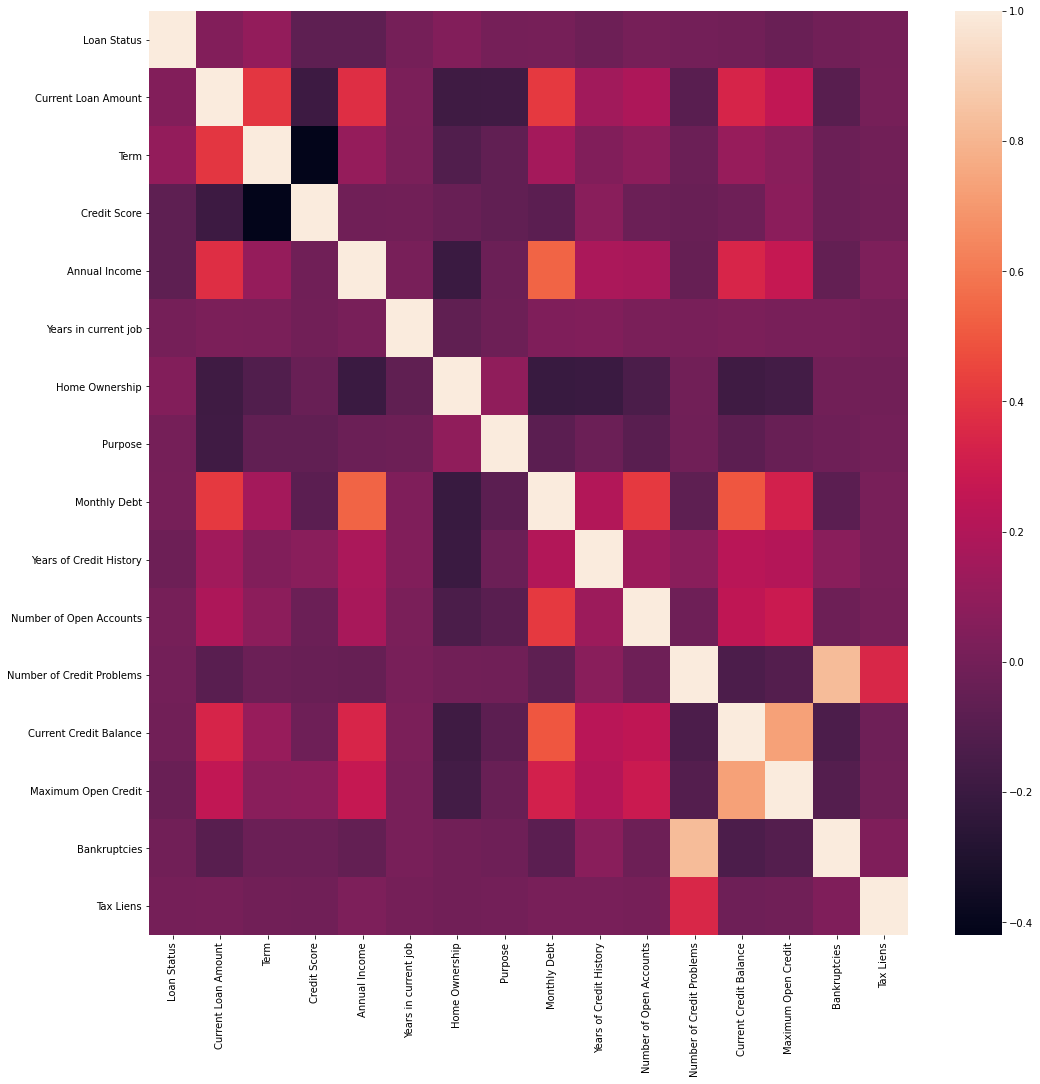

In [58]:
cor_mat = df_train.corr()
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(cor_mat);

In [59]:
data_nonbinary = pd.get_dummies(df_train_copy[nonbinary_columns])

In [60]:
for binary in binary_columns:
  elements =  df_train_copy[binary].unique()
  number = 0.0
  for i in elements:
    df_train_copy.at[df_train_copy[binary] == i, binary] = number
    number = number + 1.0
  df_train_copy[binary] = df_train_copy[binary].astype('int64')

In [61]:

data_numerical = df_train_copy[numerical_columns]

In [62]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [63]:
data = pd.concat((data_numerical, data_nonbinary, df_train_copy[binary_columns]), axis = 1)
print(data.shape)

(94052, 41)


In [64]:
data

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status,Term
0,0.795248,-0.346281,-0.224637,-1.106245,-0.141229,-1.024475,2.280922,-0.192353,-0.284364,2.913358,-0.115492,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-0.222213,0.922629,1.231962,0.899866,-0.469323,1.376156,2.280922,0.016758,0.113453,-0.343243,-0.115492,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.236738,0.129560,-0.718031,-0.811243,-0.883006,-0.424317,-0.370452,-0.108060,-0.319913,-0.343243,-0.115492,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,-0.506182,0.486441,-0.201782,-0.634502,0.201129,0.375893,2.280922,-0.509948,-0.457043,2.913358,-0.115492,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1.385687,-1.575536,1.679751,0.018306,0.629077,-1.424580,-0.370452,0.433673,-0.119324,-0.343243,-0.115492,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99978,0.717813,0.169214,-0.203316,-0.834396,0.044215,-1.224528,-0.370452,-0.153024,-0.212687,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
99982,1.021266,0.169214,-0.203316,0.209126,0.785992,0.775998,-0.370452,1.533074,0.796767,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
99988,0.018513,0.169214,-0.203316,-0.386759,1.242470,0.775998,-0.370452,-0.199297,0.283533,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99989,0.702225,0.169214,-0.203316,0.878746,-0.269614,0.976051,-0.370452,0.577786,0.001659,-0.343243,-0.115492,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [65]:
data.to_csv("processed_credit_train.csv")

In [66]:
X = data.drop('Loan Status', axis = 1) 
y = data['Loan Status']
feature_names = X.columns

In [67]:
feature_names

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpose_Medical Bills', 'Purpose_Other',
       'Purpose_major_purchase', 

In [68]:
upper_test = int(len(upper)/100*30)
upper_train = len(upper) - upper_test
upper_train

3186

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [72]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.19272753047916075

In [74]:
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

In [75]:
err_test

0.18383421791014504

In [77]:
added_accuracy = 0.19272753047916075 - 0.18383421791014504

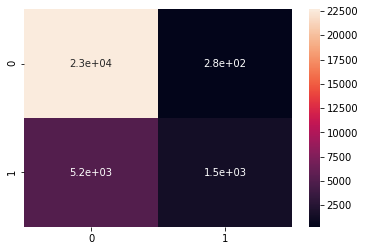

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
cm[1,1] = cm[1,1] + upper_test 
sns.heatmap(cm, annot=True)

In [79]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.19041254269022756 55


In [80]:
print(best_cv_err-added_accuracy)

0.18151923012121185


In [81]:
data_s1 = data[data["Loan Status"] == 0].sample(n=len(data[data["Loan Status"] == 1])) # Попробуем сбаланировать выборку, уменьшая ее размерность
data_s2 = data[data["Loan Status"] == 1]
data_s = data_s1.append(data_s2)

In [82]:
X = data_s.drop('Loan Status', axis = 1) 
y = data_s['Loan Status']

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [84]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [85]:

y_test_predict = knn.predict(X_test)

err_test  = np.mean(y_test  != y_test_predict)
err_test

0.4449227889564811

In [86]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

In [87]:

err_test

0.3945228215767635

In [88]:

added_accuracy = 0.44838558727187644 - 0.39759336099585063

In [89]:
cm

array([[22664,   275],
       [ 5163,  1479]])

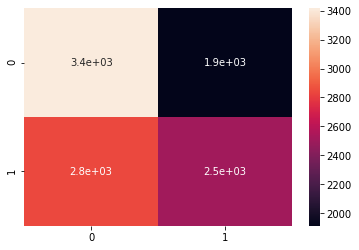

In [90]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

In [91]:
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.42116231784200253 55


In [92]:
print(best_cv_err-added_accuracy)

0.3703700915659767


Уменьшение обучающей выборки значительно ухудшает результат

## Использование PCA

In [119]:
decomposed_data = pd.read_csv("processed_credit_train.csv")
decomposed_data = decomposed_data.drop('Unnamed: 0', axis = 1)
X = decomposed_data.drop('Loan Status', axis = 1) 
y = decomposed_data['Loan Status']

In [120]:
decomposed_data.columns

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpose_Medical Bills', 'Purpose_Other',
       'Purpose_major_purchase', 

In [121]:
decomposed_train_X, decomposed_test_X, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [123]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(decomposed_train_X, y_train)
y_test_predict = dt_classifier.predict(decomposed_test_X)
err_test_dt  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"DT error test - {err_test_dt}")

svm = SVC(gamma='auto')
svm.fit(decomposed_train_X, y_train)
y_test_predict = svm.predict(decomposed_test_X)
err_test_svm  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"SVM error test - {err_test_svm}")

rfc = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
rfc.fit(decomposed_train_X, y_train) 
y_test_predict = rfc.predict(decomposed_test_X)
err_test_rf  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
print(f"RF error test - {err_test_rf}")

DT error test - 0.24725330448598762
SVM error test - 0.17839153510699435
RF error test - 0.17839153510699435


Результаты лучше, чем KNN с подбором параметров

Применим PCA

    

In [124]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2, random_state=42)

In [125]:
PCA_data = pd.read_csv("processed_credit_train.csv")
PCA_data = PCA_data.drop('Unnamed: 0', axis = 1)
X = PCA_data.drop('Loan Status', axis = 1) 
y = PCA_data['Loan Status']
feature_names = X.columns

In [126]:
decomposed_data_X = pca.fit_transform(X)
decomposed_train_X, decomposed_test_X, y_train, y_test = train_test_split(decomposed_data_X, y, test_size = 0.3, random_state = 42)

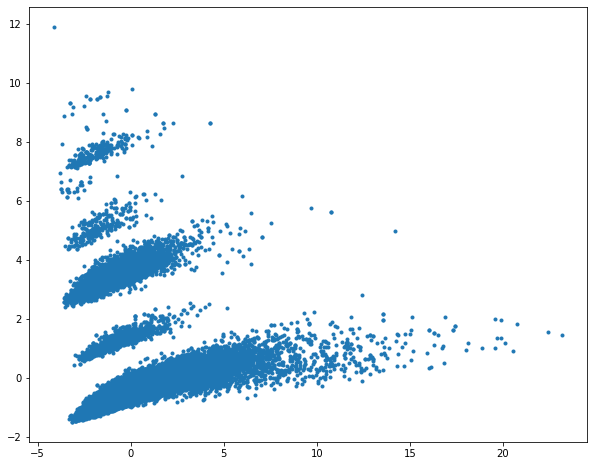

In [127]:
plt.figure(figsize=(10,8))
plt.plot(decomposed_data_X[:,0], decomposed_data_X[:,1], '.') 
plt.show()

In [128]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 55)
knn.fit(decomposed_train_X, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=55, p=2,
                     weights='uniform')

In [129]:
y_test_predict = knn.predict(decomposed_test_X)

err_test  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))
err_test

0.1784591460734931

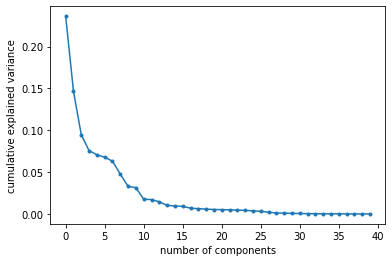

In [130]:
pca = PCA().fit(X)
plt.plot(pca.explained_variance_ratio_, '.-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [131]:
test_errors = list()

for i in [1, 2, 4, 9, 11]:
  pca = PCA(n_components=i, random_state=42)
  decomposed_data_X = pca.fit_transform(X)
  decomposed_train_X, decomposed_test_X, y_train, y_test = train_test_split(decomposed_data_X, y, test_size = 0.3, random_state = 42)

  knn = KNeighborsClassifier(n_neighbors = 55)
  knn.fit(decomposed_train_X, y_train)
  y_test_predict = knn.predict(decomposed_test_X)
  err_test_knn  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  dt_classifier = DecisionTreeClassifier()
  dt_classifier.fit(decomposed_train_X, y_train)
  y_test_predict = dt_classifier.predict(decomposed_test_X)
  err_test_dt  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  svm = SVC(gamma='auto')
  svm.fit(decomposed_train_X, y_train)
  y_test_predict = svm.predict(decomposed_test_X)
  err_test_svm  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  rfc = RandomForestClassifier(n_estimators=100, max_depth=2,
                               random_state=0)
  rfc.fit(decomposed_train_X, y_train) 
  y_test_predict = rfc.predict(decomposed_test_X)
  err_test_rf  = np.mean((y_test  != y_test_predict).append(pd.Series([False for i in range(upper_test)])))

  test_errors.append({"Num_components":i,
                      "Knn_test_errors":err_test_knn,
                      "SVM_test_errors":err_test_svm,
                      "DT_test_errors":err_test_dt,
                      "RF_test_errors":err_test_rf})
  
  print(i, err_test_knn, err_test_svm, err_test_dt, err_test_rf)

1 0.17839153510699435 0.17839153510699435 0.27375680335350394 0.17839153510699435
2 0.1784591460734931 0.17839153510699435 0.27294547175551875 0.17839153510699435
4 0.17832392414049558 0.17839153510699435 0.26533923802440756 0.17839153510699435
9 0.1784591460734931 0.17839153510699435 0.2598289442547581 0.17839153510699435
11 0.1784591460734931 0.17839153510699435 0.2621277171157162 0.17839153510699435


In [132]:
components = [i["Num_components"] for i in test_errors]  
err_test_knn = [i["Knn_test_errors"] for i in test_errors]  
err_test_svm = [i["SVM_test_errors"] for i in test_errors]  
err_test_dt = [i["DT_test_errors"] for i in test_errors]  
err_test_rf = [i["RF_test_errors"] for i in test_errors]

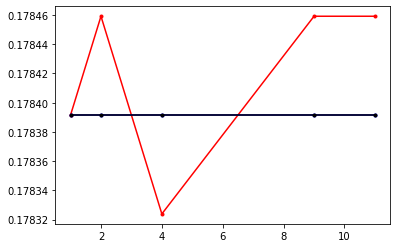

In [133]:
plt.plot(components, err_test_knn, '.-', color = "red")
plt.plot(components, err_test_svm, '.-', color = "blue") 
plt.plot(components, err_test_dt, '.', color = "pink")  # Значительно хуже остальных, ~0.27 errors
plt.plot(components, err_test_rf, '.-', color = "black")

KNN рабоатет лучше при использовании PCA. Меньшая ошибка достигается при использовании 4 главных компонент. Остальные методы работают хуже чем KNN, метод PCA не дает улучшений для остальных алгоритмов.